<img src="../code/Resources/cropped-SummerWorkshop_Header.png"> 

<h1 align="center">Workshop 1: Tutorial on neuronal encoding and behavior</h1> 
<h3 align="center">Summer Workshop on the Dynamic Brain</h3> 
<h3 align="center">Thursday, August 26th, 2025</h3> 
<h4 align="center">Day 2</h4> 

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> During the lecture, we learned about behavioral states and how they affect the processing of sensory stimuli and, consequently, motor outputs. In this workshop, we will explore how to define behavioral states and investigate both external and internal markers of state changes reflected through behavior as well as neural activity. We will examine these phenomena in mice as they perform a context-dependent decision-making task.

<p> During the task, the mice are engaged in behavior that requires them to process contextual cues, interact with their environment, and display a variety of behavioral state sequences. Meanwhile, Neuropixels electrodes record brain-wide spiking activity across the cortex and several hippocampal, striatal and thalamic areas. The behavioral task, therefore, offers an opportunity to study the dynamics of spiking activity during various behavioral states and aids in understanding the behavioral dynamics of task performance and engagement.     
</div>

<center><img src="Resources/DR_task_description.png", width="9000" height="390"> </center>

In [1]:
# add a plot of the brain areas recorded? 

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> The Dynamic Routing (DR) dataset, <a href="https://allenswdb.github.io/physiology/ephys/visual-behavior/VB-Neuropixels.html">DR Databook</a> consists of brain-wide recordings of neural activity measured using six Neuropixels probes from five mice trained to perform a context-dependent decision-making task. Throughout the session, behavior video cameras and running sensors continuously track various body parts, running speed, and pupil size of the subjects.

<p> In this go/no-go task, mice are required to selectively respond to either visual or auditory stimuli presented in alternating trial blocks. Each block, signaled by instruction trials, lasts 10 minutes. During visual blocks, mice must respond only to the visual target stimulus, while during auditory blocks, they must respond only to the auditory target stimulus. In both cases, they must suppress responses to non-target stimuli. The blocks alternate between visual and auditory modalities, and mice earn water rewards by correctly reporting (licking the reward spout) when the target stimulus appears in the currently rewarded modality.  
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The DR dataset is stored as Neurodata Without Borders (NWB) files, a standardized format for storing neurophysiology data. To access these files, we will use the Python library <a href="https://pynwb.readthedocs.io/en/stable/tutorials/index.html">pynwb</a>, which is designed for reading and writing NWB data. We begin by importing this library along with other standard Python libraries for data preprocessing and plotting.

</div>

In [2]:
# Standard library
import os  

# Data handling packages
import numpy as np  
import numpy.random as npr  
import pandas as pd 
import pynwb  

# Progress bar utility
from tqdm import tqdm  # Displays a smart progress bar during loops

# Preprocessing
from sklearn.preprocessing import StandardScaler  # Standardizes features (zero mean, unit variance)

# Plotting libraries
import matplotlib.pyplot as plt  
from matplotlib import colors  
import seaborn as sns  

# Pandas display settings
pd.set_option('display.max_columns', None)  # Ensures all columns are shown when printing DataFrames

# Inline plotting for Jupyter Notebooks
%matplotlib inline  


<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let’s examine the NWB file structure of a single experimental session and explore the metadata recorded for each behavioral trial. All experimental sessions share the same NWB structure.
</div>

In [3]:
# pick a session_id and get session data

example_session_ids = ['664851_2023-11-15', '668755_2023-08-31', '674562_2023-10-03', '759434_2025-02-04', '713655_2024-08-09']

# 664851_2023-11-13

session_id = example_session_ids[1]
nwb_path = f'/root/capsule/data/{session_id}/{session_id}.nwb'

# access the session data with pynwb
session = pynwb.NWBHDF5IO(nwb_path).read()

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [4]:
# Quick reference of the NWB file structure
# Important groups include: units, trials, epochs, and processing 

# {c.name:  c.description for c in session.trials.columns}

session

Data type,float64
Shape,"(417595,)"
Array size,3.19 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(417601,)"
Array size,3.19 MiB
Chunk shape,None


In [5]:
trials = session.trials.to_dataframe() 

trials.head(8)

,start_time,stop_time,quiescent_start_time,quiescent_stop_time,stim_start_time,stim_stop_time,response_window_start_time,response_window_stop_time,task_control_response_time,response_time,reward_time,post_response_window_start_time,post_response_window_stop_time,stim_name,block_index,rewarded_modality,trial_index,trial_index_in_block,repeat_index,is_response,is_correct,is_incorrect,is_hit,is_false_alarm,is_correct_reject,is_miss,is_go,is_nogo,is_rewarded,is_noncontingent_reward,is_contingent_reward,is_reward_scheduled,is_instruction,is_aud_stim,is_vis_stim,is_catch,is_target,is_aud_target,is_vis_target,is_nontarget,is_aud_nontarget,is_vis_nontarget,is_vis_rewarded,is_aud_rewarded,is_block_switch,is_repeat,is_opto
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2460.28081,2465.78546,2460.28081,2461.74874,2461.812369,2462.312779,2461.86548,2462.78304,2462.09900,2462.08662,2462.11572,2462.813199,2465.815729,vis1,0,vis,0,0.0,0.0,True,True,False,True,False,False,False,True,False,True,False,True,True,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False
1,2466.25251,2471.77383,2466.25251,2467.72039,2467.784039,2468.284459,2467.83720,2468.75470,2468.12079,2468.11115,2468.13746,2468.784879,2471.805099,vis1,0,vis,1,1.0,0.0,True,True,False,True,False,False,False,True,False,True,False,True,True,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False
2,2472.17423,2477.69545,2472.17423,2473.64204,2473.706659,2474.207069,2473.75881,2474.67621,2474.05909,2474.05782,2474.07584,2474.707509,2477.725719,vis1,0,vis,2,2.0,0.0,True,True,False,True,False,False,False,True,False,True,False,True,True,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False
3,2477.74550,2483.25015,2477.74550,2479.21339,2479.279011,2479.779471,2479.33018,2480.24755,2479.58037,2479.57730,2479.59702,2480.279861,2483.282361,vis1,0,vis,3,3.0,0.0,True,True,False,True,False,False,False,True,False,True,False,True,True,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False
4,2485.93568,2491.45698,2485.93568,2487.40357,2487.466841,2487.967241,2487.52038,2488.43776,2487.98740,2487.97531,2488.00406,2488.467741,2491.489161,vis1,0,vis,4,4.0,0.0,True,True,False,True,False,False,False,True,False,True,False,True,True,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False
5,2493.44195,2498.96342,2493.44195,2494.90990,2494.973519,2495.473939,2495.02667,2495.94415,2495.27681,2495.27203,2495.29352,2495.974359,2498.994499,vis1,0,vis,5,5.0,0.0,True,True,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False
6,2501.51581,2507.02004,2501.51581,2502.98326,2503.024070,2503.524070,2503.10006,2504.01760,2503.25024,2503.24579,NaN,2504.047431,2507.049911,sound1,0,vis,6,6.0,0.0,True,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,False,False,False
7,2507.30362,2512.80823,2507.30362,2508.77146,2508.813100,2509.313100,2508.88824,2509.80571,2509.18853,2509.18159,NaN,2509.836899,2512.839429,sound1,0,vis,7,7.0,0.0,True,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,False,False,False


<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let us start by examining whether the mice are able to modulate their responses to target stimuli based on the context cues. To do this, we will evaluate their hit rates for each target stimulus.
</div>

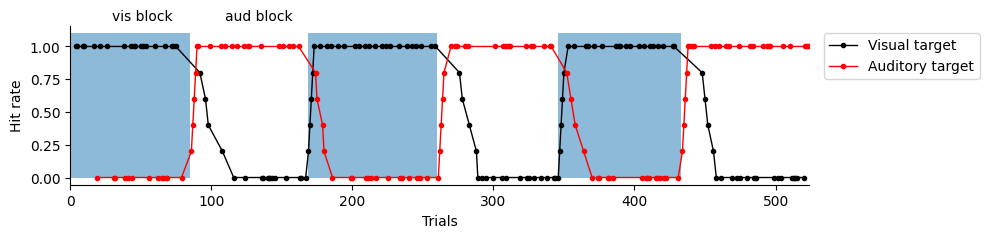

In [6]:
# hit rates to target 
vis1_hit_rate = trials[(trials["stim_name"] == 'vis1')].is_hit.rolling(5).mean()
sound1_hit_rate = trials[(trials["stim_name"] == 'sound1')].is_hit.rolling(5).mean()

fig, ax = plt.subplots(figsize = (10, 2.5))
ax.plot(vis1_hit_rate, color = 'k', marker = '.', lw = 1, label = 'Visual target')
ax.plot(sound1_hit_rate, color = 'r', marker = '.', lw = 1, label = 'Auditory target')

# add block information 
vis_block = trials.is_vis_rewarded
ax.fill_between(vis_block.index, 0, 1.1, where=vis_block == 1, alpha=0.5)
first_block = trials.iloc[0].rewarded_modality
ax.text(30,  1.2, f"{first_block} block")
ax.text(110,  1.2, "vis block" if first_block == 'aud' else "aud block")


# formatting
ax.set_xlabel('Trials')
ax.set_ylabel('Hit rate')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(bbox_to_anchor = (1.01, 1.))
ax.set_xlim(0, len(trials))
plt.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
The mouse is able to flexibly alter its responses to different context cues, suggesting a change in their cognitive state. Using this insight we can set a threshold on the hit rates to define a visual and an auditory context state. What would you set as a good threshold? 
</div>

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"> 
<p><b>Task 1.1:</b> Re-write the code below to evaluate context states using hit rates calculated on the auditory target stimulus.
</p> </div>

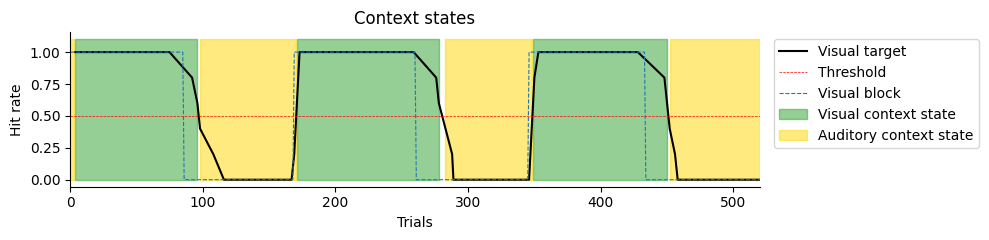

In [7]:
# response time threshold
hit_rate_threshold = 0.5

# get response times for hit trials 
vis1_trials = trials[(trials["stim_name"] == 'vis1')]
num_vis1_trials = len(vis1_trials)
vis1_hit_rate = vis1_trials.is_hit.rolling(5).mean()

# determine context states
context_states = vis1_hit_rate > hit_rate_threshold

fig, ax = plt.subplots(figsize=(10, 2.5))

# Plot hit rate
ax.plot(vis1_trials.index, vis1_hit_rate, color='k', label='Visual target')
ax.hlines(hit_rate_threshold, vis1_trials.index[0], vis1_trials.index[-1], color='r', ls='--', lw=0.5, label='Threshold')
ax.plot(trials.index, trials.is_vis_rewarded, ls='--', lw = 0.8, color = 'tab:blue', label = 'Visual block')

# context state
ax.fill_between(context_states.index, 0, 1.1, where=context_states == 1, alpha=0.5, color='tab:green', label='Visual context state')
ax.fill_between(context_states.index, 0, 1.1, where=context_states == 0, alpha=0.5, color='gold', label='Auditory context state')


# Formatting
ax.set_title('Context states')
ax.set_ylabel("Hit rate")
ax.set_xlabel("Trials")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim(vis1_trials.index[0], vis1_trials.index[-1])

# Clean legend by removing duplicates
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.01, 1.))

plt.tight_layout()


<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"> 
<p><b>Task 1.2:</b> Could you quantify the average response times for each context, including their standard deviations? We’ve provided code to access the response times for the visual block—please complete the code to calculate the response times for the auditory block.
</p> </div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> These shifts in reaction times between contexts are another marker of changes in the mouse’s cognitive state. So, when the mouse’s cognitive state changes, does it affect other aspects of its behavior too? To answer this, let’s look beyond reaction times and examine additional variables—such as running speed, pupil size, and facial movements—that might also reflect these changes in behavioral state. To avoid motor confounds during reward consumption, let’s focus our analysis on the quiescent period.</p>

</div>

In [11]:
def get_trialwise_values(x, timestamps, start, stop):
    """
    Extracts trial-wise summary statistics of different behaviors (mean or median) from a time-aligned signal.

    Parameters:
    - x : array-like
        Signal values (e.g., neural data or behavioral measurements).
    - timestamps : array-like
        Time points corresponding to each value in x.
    - start : array-like
        Start times for each trial.
    - stop : array-like
        Stop times for each trial.

    Returns:
    - values : list
        List of mean or median values for each trial window.
    """
    
    return [np.nanmean(x[np.logical_and(s1 <= timestamps, timestamps <= s2)]) 
            for s1, s2 in zip(start, stop)]

def get_facial_feature(part_name, facial_features_df):
    """
    Extracts and preprocesses the Y-coordinate of a facial feature from a dataframe.

    Parameters:
    ----------
    part_name : str
        The name of the facial feature/part.
    facial_features_df : pandas.DataFrame

    Returns:
    -------
    y : np.ndarray
        Cleaned and interpolated Y-coordinate time series of the feature.
    """

    # Extract likelihood (confidence of detection) for the feature
    confidence = facial_features_df[f'{part_name}_likelihood']

    # Extract temporal norm
    temporal_norm = facial_features_df[f'{part_name}_temporal_norm']

    # Flip Y-coordinate relative to image height
    y = 492 - facial_features_df[f'{part_name}_y']

    # Mask low-confidence or high-temporal-norm points as NaN (to discard unreliable or jumpy detections)
    y[(confidence < 0.99) | 
      (temporal_norm > np.nanmean(temporal_norm) +  2*np.nanstd(temporal_norm))] = np.nan

    # center and remove outliers
    y_centered = y - np.nanmean(y)
    y_abs_centered = np.abs(y_centered)
    y_centered[y_abs_centered > np.nanmean(y_abs_centered) + 2*np.std(y_abs_centered) ]  = np.nan

    # Interpolate missing values (NaNs) to create a continuous time series
    y_interp = pd.Series(y_centered).ffill().bfill().to_numpy()

    return y_interp


In [12]:
# access trials table and get the start and stop times
trial_start = trials.stim_start_time.values - 1.5 
trial_stop = trials.stim_start_time.values 

behavior_data = {}

# facial expressions: 
facial_features_df = session.processing['behavior']['lp_side_camera'][:]
feature_timestamps = facial_features_df['timestamps'].values.astype('float')


ear = get_facial_feature('ear_base_l', facial_features_df)
behavior_data['ear'] = get_trialwise_values(ear, feature_timestamps, trial_start, trial_stop)

nose = get_facial_feature('nose_tip', facial_features_df)
behavior_data['nose'] = get_trialwise_values(nose, feature_timestamps, trial_start, trial_stop)

jaw = get_facial_feature('jaw', facial_features_df)
behavior_data['jaw'] = get_trialwise_values(jaw, feature_timestamps, trial_start, trial_stop)

whisker_pad = get_facial_feature('whisker_pad_l_side', facial_features_df)
behavior_data['whiskers'] = get_trialwise_values(whisker_pad, feature_timestamps, trial_start, trial_stop)

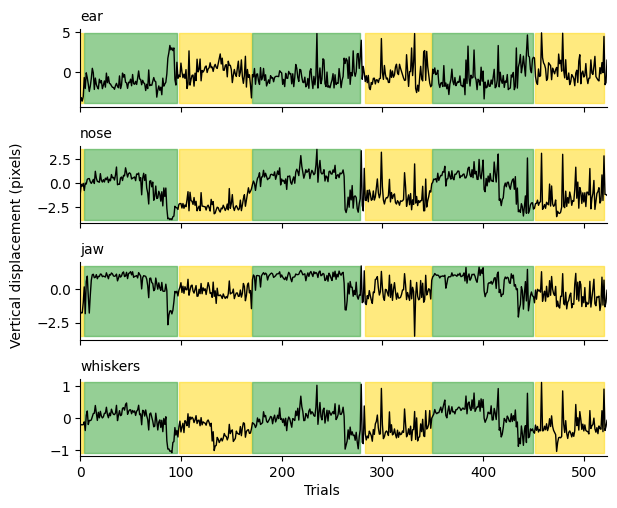

In [13]:
keys_to_plot = ['ear', 'nose', 'jaw', 'whiskers']

fig, ax = plt.subplots(4, 1, figsize = (6, 5), sharex = True)


for i, key in enumerate(keys_to_plot):
    ax[i].plot(trials.index, behavior_data[key], color = 'k', lw = 1)
    ax[i].set_title(key, fontsize = 10, loc = 'left')
    
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].set_xlim(trials.index[0], trials.index[-1])

    
    # Get min and max of this behavior trace
    min_val = np.nanmin(behavior_data[key])
    max_val = np.nanmax(behavior_data[key])
    
    # Fill between min*vis_context and max*vis_context
    ax[i].fill_between(context_states.index, min_val, max_val, where = context_states == 1, alpha=0.5, color = 'tab:green')
    ax[i].fill_between(context_states.index, min_val, max_val, where = context_states == 0, alpha=0.5, color = 'gold')

fig.text(0.5, 0.00, 'Trials', ha='center')
fig.text(-0.02, 0.5, 'Vertical displacement (pixels)', va='center', rotation='vertical')
plt.tight_layout()

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"> 
<p><b>Task 1.3:</b> Can you make similar plots for pupil size measure and running speed? 
</p> </div>

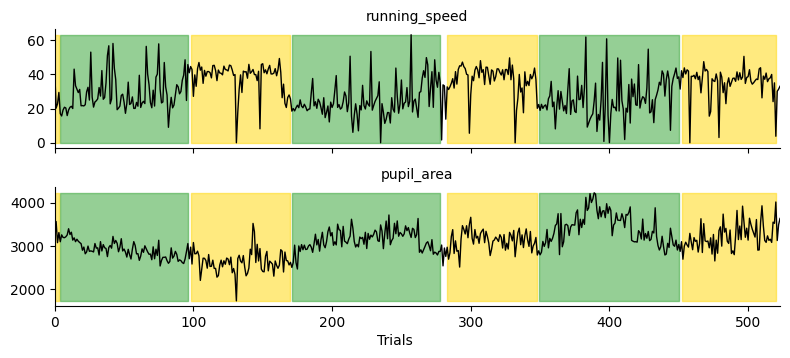

In [14]:
# running speed
running_data = session.processing['behavior']['running_speed']
running_timestamps = running_data.timestamps[:]
running_speed = running_data.data[:]
running_speed = pd.Series(running_speed).interpolate(limit_direction='both').to_numpy() 
behavior_data['running_speed'] = get_trialwise_values(running_speed, running_timestamps, trial_start, trial_stop)


# pupil area
pupil_data = session.processing['behavior']['eye_tracking']
pupil_timestamps = pupil_data.timestamps[:]
pupil_area = pupil_data.pupil_area[:]
pupil_area = pd.Series(pupil_area).interpolate(limit_direction='both').to_numpy() 
behavior_data['pupil_area'] = get_trialwise_values(pupil_area, pupil_timestamps, trial_start, trial_stop)

keys_to_plot = ['running_speed', 'pupil_area']

fig, ax = plt.subplots(2, 1, figsize = (8, 3.5), sharex = True)

for i, key in enumerate(keys_to_plot):
    ax[i].plot(trials.index, behavior_data[key], color = 'k', lw = 1)
    ax[i].set_title(key, fontsize = 10)
    
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].set_xlim(trials.index[0], trials.index[-1])

    # Get min and max of this behavior trace
    min_val = np.nanmin(behavior_data[key])
    max_val = np.nanmax(behavior_data[key])
    
    # Fill between min*vis_context and max*vis_context
    ax[i].fill_between(context_states.index, min_val, max_val, where = context_states == 1, alpha=0.5, color = 'tab:green')
    ax[i].fill_between(context_states.index, min_val, max_val, where = context_states == 0, alpha=0.5, color = 'gold')
    

fig.text(0.5, 0.00, 'Trials', ha='center')

plt.tight_layout()


<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"> 
<p><b>Task 1.4:</b> Can you evaluate the correlation between any two of these behavior variables of your interest? (Hint: scatter plot!)
</p> </div>

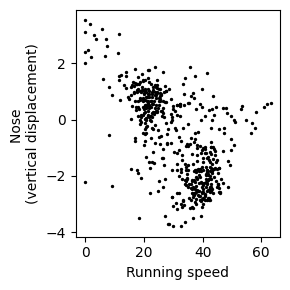

In [15]:
fig, ax = plt.subplots(figsize = (3, 3))
ax.scatter(behavior_data['running_speed'], behavior_data['nose'], color = 'k', s= 2)
ax.set_xlabel("Running speed")
ax.set_ylabel("Nose \n(vertical displacement)")
plt.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> While defining states by thresholding the hit rate is a useful starting point, it is incomple Clearly, there are several additional variables that could provide more nuanced insights into the mouse’s behavioral states.. Yet we have not incorporated these signals into our definition of behavioral states. </p>

<p>Moreover, the threshold we used to define behavioral states appeared appropriate for the mouse we studied but may not generalize across animals. How, then, can we systematically assess state changes across many mice?</p>

<p>In the remainder of this workshop, we will explore more sophisticated methods for defining behavioral states that integrate multiple behavioral signals to provide a richer, more reliable description of each mouse’s cognitive and behavioral profile.</p>
</div>


<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> First, we'll learn how to make sense of a more complex view of the behavioral information. Instead of looking at just one behavior profile, we will examine multiple variables simultaneously to gain a better understanding of what's going on. As we have seen, some of these behavior variables correlate with the behavioral state and implicitly among themselves. Let's create a visualization to see how the different behavioral variables are correlated.

</div>

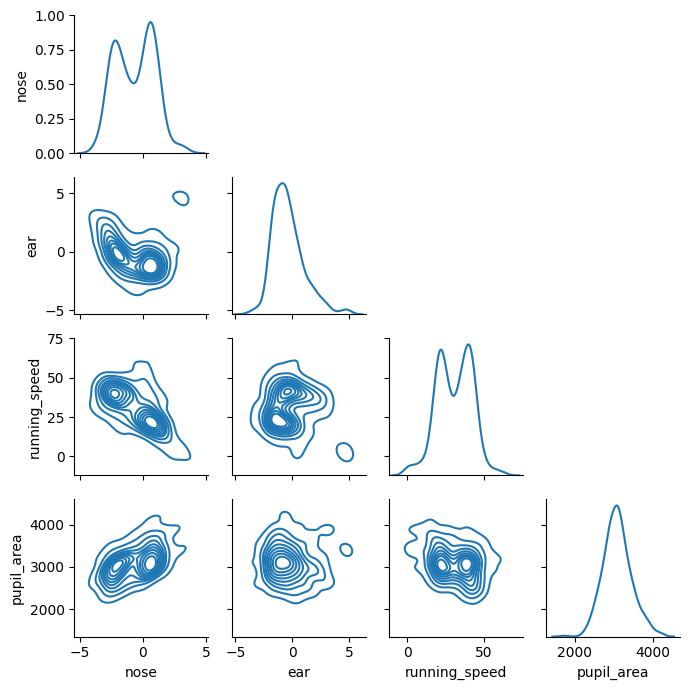

In [16]:
# convert our little dictionary into a dataframe
behavior_df = pd.DataFrame(behavior_data)


def hide_current_axis(*args, **kwds):
    # function to hide upper triangle of the pairwise plots
    plt.gca().set_visible(False)

# Set layout for pairwise plot - 4 X 4 plot grid
g = sns.PairGrid(behavior_df,  vars=['nose', 'ear', 'running_speed', 'pupil_area'], diag_sharey=False)

# Plot 2D density plot in the lower triangle 
width = 'scott' 
# *** Play around with the width of the density kernel. 
#     You can use float values between 0.1 to 1.  ****

g.map_lower(sns.kdeplot, hue=None, bw_method = width)

# Hide the upper triangle 
g.map_upper(hide_current_axis)

# Plot 1D density plot
g.map_diag(sns.kdeplot, hue=None, legend=False, bw_method = width)

# Formatting 
g.fig.set_size_inches(7,7)
g.fig.tight_layout()

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"> 
<p><b>Task 1.5: </b> In the pairwise density plots, try playing around with the option 'bw_method' by setting it to scalar values between [0.2, 1]. How does this effect the density plots? Do you still think there are only 2 states? Do this above. 
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> This visualization broadly showed two states that mapped well to our previous state definitions. But playing around with the density plots may have raised some doubts. </p>
    
<p> Does every peak deserve a behavior state? How can we define state boundaries while incorporating all behavior variables? Are there other behavior states? </p>

<p> Moreover, when determining behavioral states, we are dealing with data that changes over time, where the current state may depend on the current observation and also on the previous state. How do we incorporate time information?! </p>

<p> Lets break the problem into two parts: first, lets find out how we can incorporate a multivariate definition of behavioral states. Next, we will address the problem of incorporating time. 
    
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4>Multivariate definition of behavioral states</h4>

<p>The density plots suggest there may be multiple underlying behavioral states. One approach to identifying these states is to use unsupervised clustering methods to group similar observations across multiple behavioral variables, revealing distinct patterns that may correspond to different states.</p>

<p>K-means and Gaussian Mixture Models (GMMs) are two such clustering methods. While K-means assigns each data point to a single cluster with a deterministic assignment, GMMs allow data points to belong to multiple clusters with varying degrees of membership probabilities, making them more flexible than K-means. Unlike K-means, GMMs can model clusters with different shapes and orientations, providing a more realistic representation of the underlying structure.</p>

<p>Let’s see how we can draw a link from K-means clustering to GMMs. By making this connection, we will introduce a new tool to your toolbox: the concept of a mixture model, which seeks to maximize the likelihood of the observed data under a combination of probability distributions.</p>
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> K-means and Gaussian Mixture Models</h3>
    
<p> First, lets sort out our notation: 
<br> <b> Constants</b> 
    <ul>
        <li>$N$ - number of data points. </li>
        <li>$K$ - number of clusters/components </li>
    </ul>

<b> Data</b> 
    <ul>
        <li> $\mathbf{X} = \{x_{n}\}_{n=1}^N$ where $x_n \in \mathbb{R}^{D}$ is the $n^{th}$ data point </li>
    </ul>
    
<b> Latent Variables </b> 
    <ul>
        <li>$\mathbf{Z} = \{z_{n}\}_{n=1}^N$ wher $z_n \in \{1, ..., K\}$ is the cluster assignment for the $n^{th}$ data point </li>
    </ul>
    
<b> Parameters</b>   
    <ul> 
        <li> $\boldsymbol{\Theta} = \{\mu_k\}_{k=1}^K$ where $\mu_k \in \mathbb{R}^D$ is the mean of the $k$-th cluster </li>
    </ul>
    
<h4>K-Means</h4>
    K-Means is an algorithm for estimating the latent variables, $\mathbf{Z}$, and the parameters, $\boldsymbol{\Theta}$, given the data, $\mathbf{X}$. The algorithm alternates between two steps,
    <ol>
        <li><b>Assign</b> each data point to the closest cluster:
            \begin{align}
            z_{n} = \underset{k \in \{1,..., K\}}{\text{arg min}} || x_{n} - \mu_{k}||_{2}
            \end{align}
        </li>
        <li><b>Update</b> the parameters to the mean of the assigned data points
            \begin{align}
            \mu_{k} = \frac{1}{N_{k}}\sum_{n = 1}^{K} w_{n,k} x_{n}, 
            \end{align}
            where 
            \begin{align}
            w_{n,k} &= \begin{cases} 1 & \text{if } z_n =k \\ 0 & \text{o/w} \end{cases} \\
            N_k &= \sum_{n=1}^{N} w_{n,k}.
            \end{align}
        </li>
    </ol>
    

We can think of $w_{n,k}$ as the <i>weight</i> or <i>responsibility</i> that data point $n$ assigns to cluster $k$. 
<br>
</div>

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Question:</b> From this perspective, isn't it weird that K-Means assigns all the weight to the nearest cluster, even for points that are right on the boundary between two clusters? 
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4>Expectation-Maximization (EM)</h4>
Instead, consider the following tweak to K-Means. Instead of setting the weight to 0 or 1, set it to,
\begin{align}
    w_{n,k} &= \frac{\mathcal{N}(x_n \mid \mu_k, I)}{\sum_{j=1}^K \mathcal{N}(x_n \mid \mu_j, I)}
\end{align}
where $\mathcal{N}(x \mid \mu, \Sigma)$ denotes the <b>probability density function (pdf)</b> of a point $x_n$ under a <b>multivariate normal distribution</b> with mean $\mu$ and covariance $\Sigma$.
<br>
Then the resulting algorithm corresponds to the expectation-maximization (EM) algorithm. EM is a generic algorithm of estimating the parameters of latent variable models. In this case, it estimates the parameters $\boldsymbol{\Theta}$ of a Gaussian mixture model.


<h4>Gaussian Mixture Model (GMM)</h4>
A GMM is a probabilistic model that specifies a joint distribution over data and latent variables given parameters, 
\begin{align}
    p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\Theta}) 
    &= \prod_{n=1}^N p(x_n \mid z_n, \boldsymbol{\Theta}) \, p(z_n \mid \boldsymbol{\Theta}) \\
    &= \prod_{n=1}^N \mathcal{N}(x_n \mid \mu_{z_n}, I) \, \mathrm{Cat}(z_n \mid \tfrac{1}{K} \boldsymbol{1}_K)
\end{align}
It is a <b>generative model</b> in that we can sample latent variables and data points from the model. In one dimension, it looks like this:
<center><img src="../code/Resources/GMM.png" width="400" height="500" > </center>
<p>    
The nice thing about thinking in terms of generative models is that it allows us to extend the model in various ways. For example, 
    <ol>
        <li>We can let the clusters have <b>anisotropic covariance matrices</b> by changing the model to, 
        \begin{align}
            p(x_n \mid z_n, \boldsymbol{\Theta})
            &= \mathcal{N}(x_n \mid \mu_{z_n}, \Sigma_{z_n})
        \end{align}
        where now the parameter set consists of both means and covariance matrices, $\boldsymbol{\Theta} = \{\mu_k, \Sigma_k\}_{k=1}^K$. 
        <br>
        Then the assignment and update steps change to,
        \begin{align*}
            w_{n,k} &= \frac{\mathcal{N}(x_n \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \mathcal{N}(x_n \mid \mu_j, \Sigma_j)} \\
            \Sigma_j &= \frac{1}{N_k} \sum_{n=1}^N w_{n,k} (x_n - \mu_k) (x_n - \mu_k)^\top
        \end{align*}
        </li>
        <li>We can allow for unbalanced classes by changing the model to,
        \begin{align}
            p(z_n \mid \boldsymbol{\Theta})
            &= \mathrm{Cat}(z_n \mid \boldsymbol{\pi})
        \end{align}
        where now the parameter set includes cluster probabilities, $\boldsymbol{\Theta} = \{\mu_k, \Sigma_k, \pi_k\}_{k=1}^K$ such that $\sum_k \pi_k = 1$. 
        <br>
        Then the assignment and update steps change to,
        \begin{align*}
            w_{n,k} &= \frac{\pi_k \mathcal{N}(x_n \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n \mid \mu_j, \Sigma_j)} \\
            \pi_k &= \frac{N_k}{N}
        \end{align*}
        </li>
    </ol>
    
<h4>What are K-Means and EM really doing?</h4>
From this probabilistic perspective, we can now understand K-Means and EM as two closely related estimation algorithms. It turns out that K-Means is doing coordinate ascent on the joint probability, $p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\Theta})$, alternating between assigning data points to clusters and updating the parameters. By contrast, EM is performing coordinate ascent on a <i>lower bound</i> on the marginal probability, $p(\mathbf{X} \mid \boldsymbol{\Theta}) = \sum_{\mathbf{Z}} p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\Theta})$. 
    
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Next, let us take a brief moment to explore the sklearn Gaussian mixture models implementation to see how this generalization can be discussed in code.
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> How should we incorporate time? </h2>
<p> But its not simply enough to fit a Gaussian distribution to our behavioral data. While GMMs are a powerful tool for clustering and learning probabilistic associations in our data,they assume that each data point is independent of others. When determining behavioral states, we are dealing with data that changes over time, where the current state may depend on the current observation and also on the previous state. A choice which fulfills the goal are state-space models. 
    
<p> State space models are a framework used to understand and predict complex systems that change over time. They are particularly useful when dealing with dynamic processes that might not be directly observable but can still influence the observed data. Sound familiar? 
    
<p> The state-space model that we will be exploring in this workshop is the Gaussian hidden Markov model (HMM). 

</div>

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4> Gaussian Hidden Markov Model (HMM) </h4>
<p> A Gaussian HMM introduces the notion of dynamics to state determination. The behavior of an HMM is fully determined by three probabilties: 
  
<ol>
    <li> <b> Transition probability</b> $p(z_{t+1} \mid z_{t})$, the probability of $z_{t+1}$ given its previous state $z_t$.  We can describe the transition probability by a K $\times$ K matrix which is called transition matrix. The $(i,j)^{th}$ element of the matrix denotes the probability of the state transiting from the state $i$ to state $j$.
    </li>
    <li> <b> Emission probability </b> $p(x_{t}\mid z_{t})$, the probability of the observation $x_{t}$ given its hidden state $z_{t}$. Specifically, for a Gaussian HMM, emission probabilties take the following form, 
    \begin{align}
    p(x_t \mid z_t, \boldsymbol{\Theta}) &= \mathcal{N}(x_t \mid \mu_{z_t}, \Sigma_{z_t})
    \end{align}
    where the emission parameters $\boldsymbol{\Theta} = \{(\mu_k, \Sigma_k)\}_{k=1}^K$ include the means and covariances for each of the $K$ discrete states.
    </li>
    <li> <b> Initial state distribution </b> $p(z_{1})$ 
    </li>
</ol>
</div>

<h4 align="left">Hidden Markov models</h4> 

<center><img src="../code/Resources/gHMM.png" width="300" height="400"> </center>

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p>So, lets try out HMM models! First, let's take a moment to import our minmal set of packages. This might take a few minutes. 
    
<ul> Dynamax is a package created in collaboration between the Linderman lab and Google building around a JAX engine. JAX is a functional language which handles the backend for fast computation while presenting similarly to numpy. This means that you'll want to carry state along between calls. 
  
<p> Dynamax implements a variety of Gaussian HMMs with different constraints on the parameters (e.g. diagonal, spherical, and tied covariances). It also includes prior distributions on the parameters.

</div>

In [19]:
# HMM-related imports from JAX, Dynamax, and TensorFlow Probability
from functools import partial
import jax.numpy as jnp
import jax.random as jr
from dynamax.hidden_markov_model import GaussianHMM
import tensorflow_probability.substrates.jax.distributions as tfd
from dynamax.utils.utils import find_permutation

# Additional HMM variants and plotting utilities from Dynamax
from dynamax.hidden_markov_model import (
    DiagonalGaussianHMM,
    SphericalGaussianHMM,
    SharedCovarianceGaussianHMM
)

from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap


<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Task 1.6: </b> As we discuss these helper functions below, add to the docstring a comment about when you should use each of these helper functions. 
</div>

In [20]:
# Helper functions for plotting
def plot_gaussian_hmm(hmm, params, emissions, states,  title="Emission Distributions", alpha=0.25):
    """ This function should be used....
    
    Inputs:
    hmm: a hidden markov model class which we will use defined in dynamax, 
    params: a set of parameters which is carried along through training
    emissions: the observations in time
    states: the underlying latent state at each timepoint.
    """
    lim = 1.1 * abs(emissions).max()
    XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), jnp.linspace(-lim, lim, 100))
    grid = jnp.column_stack((XX.ravel(), YY.ravel()))

    plt.figure()
    for k in range(hmm.num_states):
        lls = hmm.emission_distribution(params, k).log_prob(grid)
        plt.contour(XX, YY, jnp.exp(lls).reshape(XX.shape), cmap=white_to_color_cmap(COLORS[k]))
        plt.plot(emissions[states == k, 0], emissions[states == k, 1], "o", mfc=COLORS[k], mec="none", ms=3, alpha=alpha)

    plt.plot(emissions[:, 0], emissions[:, 1], "-k", lw=1, alpha=alpha)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title(title)
    plt.gca().set_aspect(1.0)
    plt.tight_layout()


def plot_gaussian_hmm_data(hmm, params, emissions, states, xlim=None, title = "Simulated data from an HMM"):
    """ This function should be used....
    
    Inputs:
    hmm: a hidden markov model class which we will use defined in dynamax, 
    params: a set of parameters which is carried along through training
    emissions: the observations in time
    states: the underlying latent state at each timepoint.
    """
    num_timesteps = len(emissions)
    emission_dim = hmm.emission_dim
    means = params.emissions.means[states]
    lim = 1.05 * abs(emissions).max()

    # Plot the data superimposed on the generating state sequence
    fig, axs = plt.subplots(emission_dim, 1, sharex=True)
    
    for d in range(emission_dim):    
        axs[d].imshow(states[None, :], aspect="auto", interpolation="none", cmap=CMAP,
                      vmin=0, vmax=len(COLORS) - 1, extent=(0, num_timesteps, -lim, lim))
        axs[d].plot(emissions[:, d], "-k")
        axs[d].plot(means[:, d], ":k")
        axs[d].set_ylabel("$y_{{t,{} }}$".format(d+1))
        
    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)

    axs[-1].set_xlabel("time")
    axs[0].set_title(title)
    plt.tight_layout()

<div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Before we apply HMMs to real data, let's start with using Dynamax to introduce Gaussian HMMs on synthetic data.
</div>

In [21]:
# Set up training parameters
num_train_batches = 3
num_test_batches = 1
num_timesteps = 100

# Make an HMM and sample data and true underlying states
true_num_states = 5
observations_dim = 2
hmm = GaussianHMM(true_num_states, observations_dim)

# Set the initial state distribution
initial_probs = jnp.ones(true_num_states) / true_num_states

# Set the transition matrix
transition_matrix = 0.80 * jnp.eye(true_num_states) \
    + 0.15 * jnp.roll(jnp.eye(true_num_states), 1, axis=1) \
    + 0.05 / true_num_states

# Set the emission probabilities - mean and covariances
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.zeros((true_num_states, observations_dim - 2)),
    ])
emission_covs = jnp.tile(0.25**2 * jnp.eye(observations_dim), (true_num_states, 1, 1))
  
# Construct the HMM - this will be our ground truth 
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs)

# Separating data into batches
train_key = jr.split(jr.PRNGKey(0), 3)
train_true_states = np.zeros((num_train_batches, num_timesteps)).astype(int)
train_observations = np.zeros((num_train_batches, num_timesteps,  observations_dim))
for k in range(num_train_batches):
    train_true_states[k], train_observations[k] = hmm.sample(key = train_key[k], params=true_params, num_timesteps=num_timesteps)


<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Lets visualize how the HMM was modeled. For this, we can plot the 2D-data, and superimpose each states' Gaussian fit. 
</div>

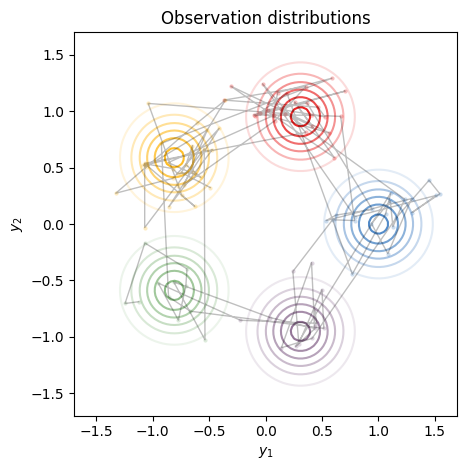

In [22]:
# Plot emissions and true_states 
plot_gaussian_hmm(hmm, true_params, train_observations[0], train_true_states[0], 
                  title="Observation distributions")

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Task 1.7: </b> How does the HMM data change as you alter the transition matrix? How does it change when you alter the emission variance? You can also try to play with the initial state distribution. 
</div>

In [23]:
"""
Starter code for you to change these parameters for task 1.7

# Set up training parameters
num_train_batches = 3
num_test_batches = 1
num_timesteps = 100

# Make an HMM and sample data and true underlying states
true_num_states = 5
observations_dim = 2
hmm = GaussianHMM(true_num_states, observations_dim)

# Set the initial state distribution
initial_probs = jnp.ones(true_num_states) / true_num_states

# Set the transition matrix
transition_matrix = 0.80 * jnp.eye(true_num_states) \
    + 0.15 * jnp.roll(jnp.eye(true_num_states), 1, axis=1) \
    + 0.05 / true_num_states

# Set the emission probabilities - mean and covariances
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.zeros((true_num_states, observations_dim - 2)),
    ])
emission_covs = jnp.tile(0.25**2 * jnp.eye(observations_dim), (true_num_states, 1, 1))
  
# Construct the HMM - this will be our ground truth 
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs)

# Set up training, validation, and test datasets
train_key = jr.split(jr.PRNGKey(0), 3)
train_true_states = np.zeros((num_train_batches, num_timesteps)).astype(int)
train_observations = np.zeros((num_train_batches, num_timesteps,  observations_dim))
for k in range(num_train_batches):
    train_true_states[k], train_observations[k] = hmm.sample(key = train_key[k], params=true_params, num_timesteps=num_timesteps)

"""

print('')

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> By plotting these states as a function of time, the interplay between descrete latent states, transition matrix mediated dynamics (Markov process) and the observations (or emissions) becomes more clear.
</div>

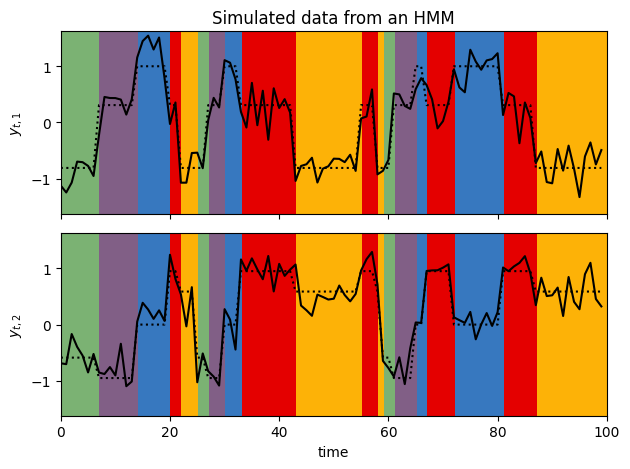

In [24]:
# Plot emissions vs. time with background colored by true state
plot_gaussian_hmm_data(hmm, true_params, train_observations[0], train_true_states[0])

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> In previous days, we've seen the vitial importance of cross-validation as a saneity check on your data to avoid overfitting. Let's bring those principles in here.
    
<p> This function fits the data into _folds_ where each fold consists of all but one of the training sequences. It fits the model to each fold in  parallel, and then computs the log likelihood of the held-out sequence for each fold. The average held-out log likelihood is what we will use for determining the number of discrete states.
</div>


In [25]:
def cross_validate_model(model, key, num_iters=100):
    
    # Initialize the parameters using K-Means on the full training set
    params, props = model.initialize(key=key, method='kmeans', emissions=train_observations)
    
    # Split the training data into folds.
    folds = jnp.stack([
        jnp.concatenate([train_observations[:i], train_observations[i+1:]])
        for i in range(num_train_batches)
    ])
    
    def _fit_fold(y_train, y_val):
        # Funtion to fit the HMM
        fit_params, train_lps = model.fit_em(params, props, y_train, 
                                             num_iters=num_iters, verbose=False)
        return model.marginal_log_prob(fit_params, y_val)
    
    val_lls = np.zeros(num_train_batches)
    for k in range(num_train_batches): 
        y_val = train_observations[k]
        y_train = train_observations[list(set(np.arange(num_train_batches))  - set([k]))]
        # print(f.shape, train_observations.shape)
        val_lls[k] = _fit_fold(y_train, y_val)
        
    return val_lls.mean(), val_lls

In [26]:
# Make a range of Gaussian HMMs
all_num_states = list(range(2, 10))
test_hmms = [GaussianHMM(num_states, observations_dim, transition_matrix_stickiness=10.) 
          for num_states in all_num_states]
results = []


for test_hmm in test_hmms:
    print(f"fitting model with {test_hmm.num_states} states")
    results.append(cross_validate_model(test_hmm, jr.PRNGKey(0)))
    
avg_val_lls, all_val_lls = tuple(zip(*results))

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states
fitting model with 7 states
fitting model with 8 states
fitting model with 9 states


<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Task 1.8:</b>  Plot up the average validation log-likelihood and discuss with your neighbor the implications of this curve shape? If you didn't know how many true states there where, how would you decide when to stop adding states? Will this lesson generalize to other types of data?
</div>

In [27]:
# Blank coding cell to work out Task 2.1

# plt.figure(figsize = (4, 3))
# plt.plot
# for k, per_fold_val_lls in zip(all_num_states, all_val_lls):
#     plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
# plt.xlabel("num states ($K$)")
# plt.ylabel("avg. validation log prob.")
# plt.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> How should we choose the right number of states? 
    
<p> There's no single "right" answer for how to choose the number of states, but reasonable heuristics include:
    
<ul> * picking $K$ that has the highest average validation log prob
<p> * picking $K$ where the average validation log prob stops increasing by a minimum amount
<p> * picking $K$ with a hypothesis test for increasing mean
<p> * picking $K$ consistent with the predicability-computability-stability (PCS) framework.
    
<p> Here, we'll just choose the number of states with the highest average.
</div>


In [28]:
best_num_states = all_num_states[jnp.argmax(jnp.stack(avg_val_lls))]
print("best number of states:", best_num_states)

best number of states: 5


<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Now let's fit our model with the best number of states. Using the number of states with the highest loglikelihood average, we can fit our Gaussian HMM.
</div>

In [29]:
# Initialize the parameters using K-Means on the full training set
key = jr.PRNGKey(0)
test_hmm = GaussianHMM(best_num_states, observations_dim, transition_matrix_stickiness=10.)
params, props = test_hmm.initialize(key=key, method="kmeans", emissions=train_observations)
params, lps = test_hmm.fit_em(params, props, train_observations, num_iters=100)

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Task 1.9:</b>  Plot up the log-likelihood and compare it to the actual lp.
</div>

In [30]:
# Helper code for task 2.5

# Evaluate the log probability of the training data under the true parameters

# Plot log probs vs num_iterations for task 2.5

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Task 1.10:</b>  Compare the inferred states to the actual states by using the plot_gaussian_hmm_data() method for both the inferred and actual states. Discuss with your neighbors what you observe and if you can spot any errors.
    
<p> If you finish early, please consider which of the features of this data would make it more difficult to reconstruct and what you might expect the failure to look like. What would happen if you choose too many states? Too few?
    
<p> hint:  use the method: hmm.most_likely_states(params, observations)    
</div>

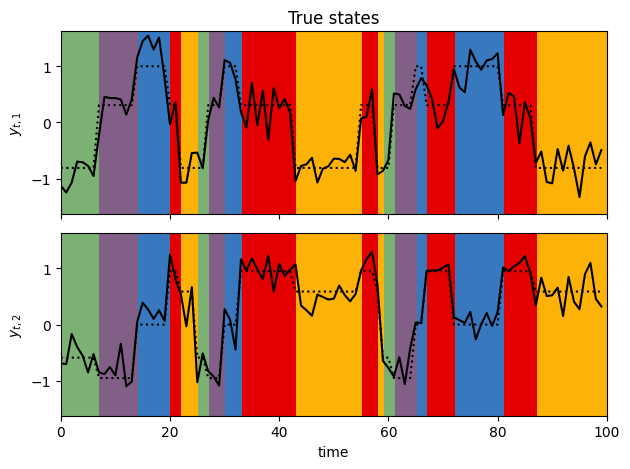

In [31]:
# helper code for task 2.6

plot_gaussian_hmm_data(hmm, true_params, train_observations[0], train_true_states[0], title = 'True states')

# Get inferred states

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> State determination in Dynamic Routing data </h3>
<p> We now kind of get a hang of HMM. So, let's take what we've done above and apply it to the behavior variables from the previous workshop to automatically detect states in our mice! Now, we have the capability to incorporate a multi-dimensional dataset to inform our state boundaries. 
<p> To accomplish this goal, we will fit our data to a Gaussian HMM. 
    
<p> To complement our states from the previous workshop, lets extract the behavior states using only behavior data, that is, pupil size, running speed and lick counts.
</div>

In [32]:
# For this model, it's important that the data is converted into a *JAX* array
observations = jnp.array(behavior_df.values)
num_trials, num_dimensions = observations.shape

# First scale the dimensions of the data to be normalized
scaler = StandardScaler()    
observations = scaler.fit_transform(observations)

# Split the data into equal length batches for cross-validation
n_batches = 6
n_steps = num_trials - (num_trials % n_batches)
batched_observations = observations[:n_steps, :].reshape(n_batches, -1, observations.shape[1])
batch_size = batched_observations.shape[1]

In [33]:

# Define empty lists that we'll populate below
avg_test_log_probs = []
all_test_log_probs = []
std_test_log_probs = []
similarity_of_states_across_batches = []

key = jr.PRNGKey(0)
num_states_range = np.arange(1, 6)
# Run a loop to fit the data to a range of states
for num_states in num_states_range:
    print(f"\n{'='*40}\nTraining model with {num_states} state(s)\n{'='*40}")

    test_log_probs = []
    
    predicted_states = np.zeros([num_trials, n_batches], dtype = int)
    
    for batch in range(n_batches):
        # Extract all but this batch for training
        train_observations = np.concatenate([batched_observations[:batch], batched_observations[batch+1:]])#.reshape((n_batches - 1)*batch_size, -1)
        flat_train_observations = train_observations.reshape((n_batches - 1) * batch_size, -1)
        if num_states == 1:
            train_mean = jnp.mean(flat_train_observations, axis=0).reshape([1,num_dimensions])
            train_cov = jnp.cov(flat_train_observations.T)
            test_data = jnp.array(batched_observations[batch])    #scaler.transform(jnp.array(batched_observations[batch]))
            test_lp = tfd.MultivariateNormalFullCovariance(train_mean, train_cov).log_prob(batched_observations[batch]).sum()
        else:
            # Make an HMM
            hmm = GaussianHMM(num_states, num_dimensions, transition_matrix_stickiness=10.)
            params, param_props = hmm.initialize(key=key, method="kmeans", emissions=jnp.array(train_observations))

            # Fit the model
            params, lps = hmm.fit_em(params, param_props, jnp.array(train_observations), num_iters=500)
            
            #extract predicted states
            predicted_states[:,batch] = hmm.most_likely_states(params, observations)

            # Evaluate the log probability on held out data
            test_lp = hmm.marginal_log_prob(params, jnp.array(batched_observations[batch]))
        test_log_probs.append(test_lp)

    # Calculate the similarity of each set of predicted states
    if batch != 1:
        distance_between_batches = []
        for i in range(n_batches):
            for j in range(i-1):
                bestpermutation = find_permutation(predicted_states[:,i], predicted_states[:,j])
                distance_between_batches.append(np.sum(jnp.take(bestpermutation, predicted_states[:,i]) == predicted_states[:,j])/observations.shape[0])
        similarity_of_states_across_batches.append(np.mean(distance_between_batches))
    else:
        similarity_of_states_across_batches.append(1)
        
    # Store the average test log prob
    all_test_log_probs.append(test_log_probs)
    avg_test_log_probs.append(np.nanmean(test_log_probs))
    std_test_log_probs.append(np.nanstd(test_log_probs))    


Training model with 1 state(s)

Training model with 2 state(s)



Training model with 3 state(s)



Training model with 4 state(s)



Training model with 5 state(s)


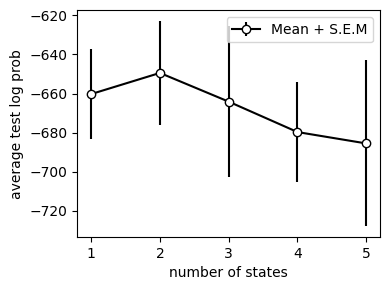

In [34]:
plt.figure(figsize = (4, 3))
plt.errorbar(num_states_range, avg_test_log_probs, yerr = np.array(std_test_log_probs)/np.sqrt(n_batches), mfc = 'w', color = 'k', marker = 'o')

# If you like, you can plot up each of the log_probs from the session.
#for k, test_log_probs in zip(num_states_range, all_test_log_probs):
#    plt.plot(k * np.ones(n_batches), test_log_probs, 'r.')

plt.legend(['Mean + S.E.M'])
plt.xlabel("number of states")
plt.ylabel("average test log prob")
plt.tight_layout()

In [35]:
key = jr.PRNGKey(0)
best_num_states = 2
number_of_states = best_num_states 
final_hmm = GaussianHMM(number_of_states, num_dimensions, transition_matrix_stickiness=10.)
params, param_props = final_hmm.initialize(key=key, method="kmeans", emissions=jnp.array(observations))
params, lps = final_hmm.fit_em(params, param_props, jnp.array(observations), num_iters=500)


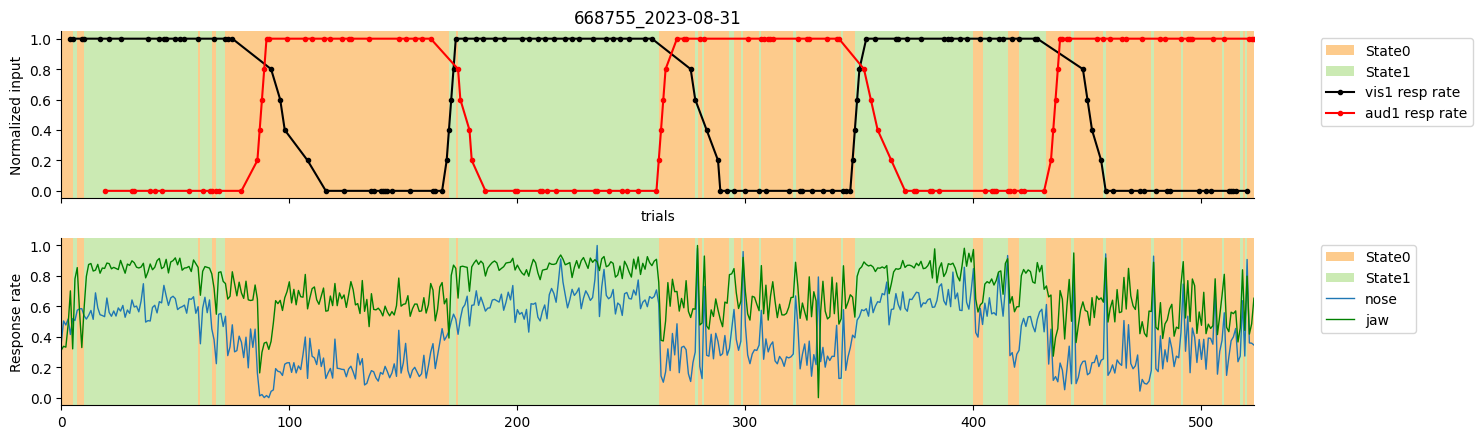

In [36]:
go_trials = np.arange(len(trials))

def minmax(x):
    # Function to normalize the data for easy visualization
    return (x - np.min(x))/(np.max(x) - np.min(x)) 


# Find the most likely discrete states given the learned model parameters
most_likely_states = final_hmm.most_likely_states(params, observations)

# Overlay the precision and recall curves on top of the inferred states
fig, ax = plt.subplots(2, 1, figsize=(15, 4.5), sharex=True)
cmap =sns.color_palette("Spectral", best_num_states)
bounds=np.arange(-0.5, best_num_states, 0.5)

# Define state boundaries 
states = most_likely_states
switch_trials = np.where(np.diff(states))[0]
switch_trials = np.concatenate(([0], switch_trials, [len(go_trials)-1]))

# Plot the states 
for j in range(2):
    for i, trial in enumerate(switch_trials[:-1]):
        for state_no in range(best_num_states):
            if states[trial+1] == state_no: 
                ax[j].axvspan(go_trials[trial], go_trials[switch_trials[i+1]], 
                        facecolor= cmap[state_no], alpha=0.8, label = 'State' + str(state_no))


# ax[0].plot(sound1_response_rate, color = 'k', label = 'sound1 resp rate', marker='.')
ax[0].plot(vis1_hit_rate, color = 'k', label = 'vis1 resp rate', marker = '.')
ax[0].plot(sound1_hit_rate, color = 'r', label = 'aud1 resp rate', marker = '.')



# Overlay behavioral variables 
ax[1].plot(go_trials, minmax(behavior_df['nose']), color = 'tab:blue', label="nose", lw = 1)
ax[1].plot(go_trials, minmax(behavior_df['jaw']), color = 'green', label="jaw", lw = 1)



# Formatting 
ax[0].set_xlim(go_trials[0], go_trials[-1])
ax[0].set_title(f'{session_id}')
ax[0].set_ylabel("Normalized input")
ax[0].set_xlabel("trials")
handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0].legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.05, 1), fontsize = 10)

ax[1].set_ylabel('Response rate')

handles, labels = ax[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[1].legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.05, 1), fontsize = 10)


for j in range(2): 
    ax[j].spines["top"].set_visible(False)
    ax[j].spines["right"].set_visible(False)


plt.tight_layout()

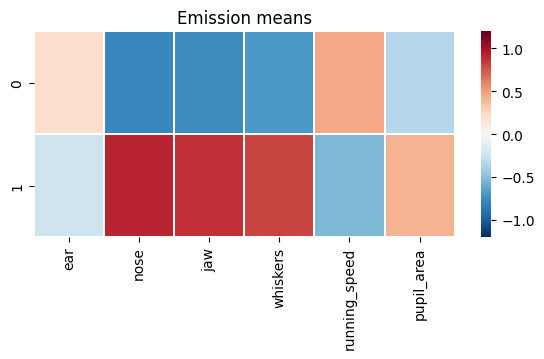

In [37]:
plt.figure(figsize = (5.8, 3.7))
sns.heatmap(params.emissions.means, xticklabels = behavior_df.keys(), yticklabels= np.arange(number_of_states), cmap = 'RdBu_r', linewidths=0.2, vmax = 1.2, vmin = -1.2)
plt.title('Emission means')
plt.tight_layout()